# Introduction

This is the implementation of our PD progression subtyping method on PPMI cohort from AMP-PD.

# Install software

Run this section as setup step.

You may occasionally need to re-run this notebook to re-install or update software if the notebook runtime environment changes or is restarted.

## Python package

In [124]:
!pip3 install numpy  # Install Numpy
!pip3 install matplotlib  # Install Matplotlib
!pip3 install torch==1.4.0+cpu torchvision==0.5.0+cpu -f https://download.pytorch.org/whl/torch_stable.html  # Install PyTorch

Looking in links: https://download.pytorch.org/whl/torch_stable.html


## Facets

In [125]:
import os

if not os.path.exists('facets'):
    !git clone https://github.com/pair-code/facets.git
else:
    print('Facets already installed.')

!jupyter nbextension install facets/facets-dist/ --user

Facets already installed.
Up to date: /home/jupyter-user/.local/share/jupyter/nbextensions/facets-dist/facets-jupyter.html

    To initialize this nbextension in the browser every time the notebook (or other app) loads:
    
          jupyter nbextension enable <the entry point> --user
    


## Provenance

In [126]:
import datetime
print(datetime.datetime.now())

2020-03-17 21:29:34.808496


In [127]:
!pip3 freeze

pandas==0.24.2
pandas-gbq==0.13.1
six==1.14.0
torch==1.4.0+cpu
torchvision==0.5.0+cpu


# Data preparation

This section will extract the data from Google BigQuery into a dataframe and then impute and normalize the extracted data.

## Install software

Before executing the code in this section, be sure to have run the section Py3 - Install software.

## Load libraries

In [128]:
import pandas as pd
import numpy as np
import os
import time
import re
import copy
import pickle as pkl
import json
from firecloud import api as fapi

## Setup utility classes

The data to be extracted can be divided into static data and longitude data. Most static data are come from the demographic information, such as age, gender, race and so on. The longitude data are come from the others category dataset, such as motor clinical assessments, non-motor clinical assessments and so on.

There are four cohort can be explored in this study, they are PPMI, PDBP, HBS and BioFIND. The static data could contain the demographic inforamtion and the family history information. The longitude data could contain the data from the MDS-UPDRS Part I - IV, Schwab and England ADL scale, Montreal Cognitive Assessment (MoCA), University of Pennsylvania Smell Identification Test (UPSIT), REM Sleep Behavior Disorder Questionnaire, Epworth Sleepiness Scale, 
medical records and the biospecimen.

Class "DataPreparation" will generate the static data and longitude data from the selected cohort and data table in the study. As well as the patients' visit information and features for futher process will be also generated.

Then, the function "concatenate" will convert the generated longitude data into the format for feeding LSTM model. Function "interpolate_imputation" and "LOCF_FOCB_imputation" are used to impute the converted data, and funtion "Z_score_normalization" and "minmax_normalization" are used to normalize the data.

In [129]:
class DataPreparation():
    
    def __init__(self, cohort_name, table_list):
        
        self.table_list = table_list
        
        self.BILLING_PROJECT_ID = os.environ['GOOGLE_PROJECT']
        WORKSPACE_NAMESPACE = os.environ['WORKSPACE_NAMESPACE']
        WORKSPACE_NAME = os.environ['WORKSPACE_NAME']

        WORKSPACE_ATTRIBUTES = fapi.get_workspace(WORKSPACE_NAMESPACE, WORKSPACE_NAME).json().get('workspace',{}).get('attributes',{})
        WORKSPACE_ENTITIES = fapi.get_entities_with_type(WORKSPACE_NAMESPACE, WORKSPACE_NAME).json()
        
        COHORT_NAME = cohort_name
        cohort_data = None
        for entity in WORKSPACE_ENTITIES:
            if entity['entityType'] != 'cohort':
                continue
            if entity['name'] == COHORT_NAME:
                cohort_data = entity
                break

        assert cohort_data, f"STOP! '{COHORT_NAME}' not found, please follow instructions above to create a cohort with this name"

        cohort_query = cohort_data['attributes']['query']
        
        cohort_df = self.bq_query(cohort_query)
        pid_list = cohort_df['participant_id'].values.tolist()
        self.patient_list = pid_list
        
        self.participant_df = self.bq_query(f'''
        SELECT d.*, h.* EXCEPT(participant_id)
        FROM `amp-pd-research.2019_v1release_1015.Demographics` AS d
        JOIN `amp-pd-research.2019_v1release_1015.amp_pd_case_control` AS h
        USING (participant_id)
        WHERE d.participant_id IN ({cohort_query})''')
        
        history_df = self.bq_query(f'''SELECT * FROM `amp-pd-research.2019_v1release_1015.Family_History_PD`''')
        updrs1_df = self.bq_query(f'''SELECT * FROM `amp-pd-research.2019_v1release_1015.MDS_UPDRS_Part_I`''')
        updrs2_df = self.bq_query(f'''SELECT * FROM `amp-pd-research.2019_v1release_1015.MDS_UPDRS_Part_II`''')
        updrs3_df = self.bq_query(f'''SELECT * FROM `amp-pd-research.2019_v1release_1015.MDS_UPDRS_Part_III`''')
        updrs4_df = self.bq_query(f'''SELECT * FROM `amp-pd-research.2019_v1release_1015.MDS_UPDRS_Part_IV`''')
        schwab_df = self.bq_query(f'''SELECT * FROM `amp-pd-research.2019_v1release_1015.Modified_Schwab___England_ADL`''')
        moca_df = self.bq_query(f'''SELECT * FROM `amp-pd-research.2019_v1release_1015.MOCA`''')
        upsit_df = self.bq_query(f'''SELECT * FROM `amp-pd-research.2019_v1release_1015.UPSIT`''')
        ess_df = self.bq_query(f'''SELECT * FROM `amp-pd-research.2019_v1release_1015.Epworth_Sleepiness_Scale`''')
        rbd_df = self.bq_query(f'''SELECT * FROM `amp-pd-research.2019_v1release_1015.REM_Sleep_Behavior_Disorder_Questionnaire_Stiasny_Kolster`''')
        medication_df = self.bq_query(f'''SELECT * FROM `amp-pd-research.2019_v1release_1015.PD_Medical_History`''')
        bio_df = self.bq_query(f'''SELECT * FROM `amp-pd-research.2019_v1release_1015.Biospecimen_analyses_CSF_abeta_tau_ptau`''')

        self.history_df = history_df.loc[history_df['participant_id'].isin(pid_list)]
        self.updrs1_df = updrs1_df.loc[updrs1_df['participant_id'].isin(pid_list)]
        self.updrs2_df = updrs2_df.loc[updrs2_df['participant_id'].isin(pid_list)]
        self.updrs3_df = updrs3_df.loc[updrs3_df['participant_id'].isin(pid_list)]
        self.updrs4_df = updrs4_df.loc[updrs4_df['participant_id'].isin(pid_list)]
        self.schwab_df = schwab_df.loc[schwab_df['participant_id'].isin(pid_list)]
        self.moca_df = moca_df.loc[moca_df['participant_id'].isin(pid_list)]
        self.upsit_df = upsit_df.loc[upsit_df['participant_id'].isin(pid_list)]
        self.ess_df = ess_df.loc[ess_df['participant_id'].isin(pid_list)]
        self.rbd_df = rbd_df.loc[rbd_df['participant_id'].isin(pid_list)]
        self.medication_df = medication_df.loc[medication_df['participant_id'].isin(pid_list)]
        self.bio_df = bio_df.loc[bio_df['participant_id'].isin(pid_list)]
        
        demographics = self.extract_demographics()
        history = self.extract_history()
        updrs1 = self.extract_updrs1()
        updrs2 = self.extract_updrs2()
        updrs3 = self.extract_updrs3()
        updrs4 = self.extract_updrs4()
        schwab = self.extract_schwab()
        moca = self.extract_moca()
        upsit = self.extract_upsit()
        ess = self.extract_ess()
        rbd = self.extract_rbd()
        med = self.extract_medication()
        bio = self.extract_bio()
        
        self.table_dict = {"demographics": demographics, "history": history, "updrs1": updrs1, "updrs2": updrs2, "updrs3": updrs3, "updrs4": updrs4,
                          "schwab": schwab, "moca": moca, "upsit": upsit, "ess": ess, "rbd": rbd, "med": med, "bio": bio}
        
        self.feature_knowledge = ["code_upd2101_cognitive_impairment", "code_upd2102_hallucinations_and_psychosis", "code_upd2103_depressed_mood", 
                "code_upd2104_anxious_mood", "code_upd2105_apathy", "code_upd2106_dopamine_dysregulation_syndrome_features", 
                "code_upd2107_pat_quest_sleep_problems", "code_upd2108_pat_quest_daytime_sleepiness", 
                "code_upd2109_pat_quest_pain_and_other_sensations", "code_upd2110_pat_quest_urinary_problems", 
                "code_upd2111_pat_quest_constipation_problems", "code_upd2112_pat_quest_lightheadedness_on_standing", 
                "code_upd2113_pat_quest_fatigue", "code_upd2201_speech", "code_upd2202_saliva_and_drooling", "code_upd2203_chewing_and_swallowing", 
                "code_upd2204_eating_tasks", "code_upd2205_dressing", "code_upd2206_hygiene", "code_upd2207_handwriting", 
                "code_upd2208_doing_hobbies_and_other_activities", "code_upd2209_turning_in_bed", "code_upd2210_tremor", 
                "code_upd2211_get_out_of_bed_car_or_deep_chair", "code_upd2212_walking_and_balance", "code_upd2213_freezing", 
                "code_upd2301_speech_problems", "code_upd2302_facial_expression", "code_upd2303a_rigidity_neck", 
                "code_upd2303b_rigidity_rt_upper_extremity", "code_upd2303c_rigidity_left_upper_extremity", 
                "code_upd2303d_rigidity_rt_lower_extremity", "code_upd2303e_rigidity_left_lower_extremity", 
                "code_upd2304a_right_finger_tapping", "code_upd2304b_left_finger_tapping", "code_upd2305a_right_hand_movements", 
                "code_upd2305b_left_hand_movements", "code_upd2306a_pron_sup_movement_right_hand", "code_upd2306b_pron_sup_movement_left_hand", 
                "code_upd2307a_right_toe_tapping", "code_upd2307b_left_toe_tapping", "code_upd2308a_right_leg_agility", 
                "code_upd2308b_left_leg_agility", "code_upd2309_arising_from_chair", "code_upd2310_gait", "code_upd2311_freezing_of_gait", 
                "code_upd2312_postural_stability", "code_upd2313_posture", "code_upd2314_body_bradykinesia", 
                "code_upd2315a_postural_tremor_of_right_hand", "code_upd2315b_postural_tremor_of_left_hand", 
                "code_upd2316a_kinetic_tremor_of_right_hand", "code_upd2316b_kinetic_tremor_of_left_hand", 
                "code_upd2317a_rest_tremor_amplitude_right_upper_extremity", "code_upd2317b_rest_tremor_amplitude_left_upper_extremity", 
                "code_upd2317c_rest_tremor_amplitude_right_lower_extremity", "code_upd2317d_rest_tremor_amplitude_left_lower_extremity", 
                "code_upd2317e_rest_tremor_amplitude_lip_or_jaw", "code_upd2318_consistency_of_rest_tremor", 
                "mod_schwab_england_pct_adl_score", 
                "moca01_alternating_trail_making", "moca02_visuoconstr_skills_cube", "moca03_visuoconstr_skills_clock_cont", 
                "moca04_visuoconstr_skills_clock_num", "moca05_visuoconstr_skills_clock_hands", "moca06_naming_lion", 
                "moca07_naming_rhino", "moca08_naming_camel", "moca09_attention_forward_digit_span", 
                "moca10_attention_backward_digit_span", "moca11_attention_vigilance", "moca12_attention_serial_7s", 
                "moca13_sentence_repetition", "moca14_verbal_fluency_number_of_words", "moca15_verbal_fluency", 
                "moca16_abstraction", "moca17_delayed_recall_face", "moca18_delayed_recall_velvet", "moca19_delayed_recall_church", 
                "moca20_delayed_recall_daisy", "moca21_delayed_recall_red", "moca22_orientation_date_score", 
                "moca23_orientation_month_score", "moca24_orientation_year_score", "moca25_orientation_day_score", 
                "moca26_orientation_place_score", "moca27_orientation_city_score", "moca_total_score", 
                "code_ess0101_sitting_and_reading", "code_ess0102_watching_tv", "code_ess0103_sitting_inactive_in_public_place", 
                "code_ess0104_passenger_in_car_for_hour", "code_ess0105_lying_down_to_rest_in_afternoon", 
                "code_ess0106_sitting_and_talking_to_someone", "code_ess0107_sitting_after_lunch", "code_ess0108_car_stopped_in_traffic", 
                "code_rbd01_vivid_dreams", "code_rbd02_aggressive_or_action_packed_dreams", "code_rbd03_nocturnal_behaviour", 
                "code_rbd04_move_arms_legs_during_sleep", "code_rbd05_hurt_bed_partner", "code_rbd06_1_speaking_in_sleep", 
                "code_rbd06_2_sudden_limb_movements", "code_rbd06_3_complex_movements", "code_rbd06_4_things_fell_down", 
                "code_rbd07_my_movements_awake_me", "code_rbd08_remember_dreams", "code_rbd09_sleep_is_disturbed", 
                "code_rbd10a_stroke", "code_rbd10b_head_trauma", "code_rbd10c_parkinsonism", "code_rbd10d_rls", "code_rbd10e_narcolepsy", 
                "code_rbd10f_depression", "code_rbd10g_epilepsy", "code_rbd10h_brain_inflammatory_disease", "code_rbd10i_other", 
                "Tau", "Abeta", "p-Tau"]
    
    def query(self):
        new_dict = {}
        for table_name in self.table_list:
            new_dict[table_name] = self.table_dict[table_name]
        return new_dict
            
    def static_data(self, save_path=None):
        if save_path is not None:
            if not os.path.exists(save_path):
                os.mkdir(save_path)
            with open(save_path + '/static_info.csv', 'w') as f:
                f.write(self.participant_df.to_csv(index=False))
        return self.participant_df
    
    def longitudinal_data(self, save_path=None):
        selected_table = self.query()
        res_df = pd.DataFrame()
        feature_list = []
        for table_name in selected_table:
            temp_feature_list = list(selected_table[table_name].drop_duplicates(subset='variable', keep='first')['variable'].values)
            feature_list = feature_list + temp_feature_list
            res_df = pd.concat([res_df, selected_table[table_name]], ignore_index=True)
            
        res_df = res_df.replace("Yes", 1)
        res_df = res_df.replace("No", 0)
        res_df = res_df.replace("None", np.nan)
        feature_list = list(set(self.feature_knowledge) & set(feature_list))
        
        if save_path is not None:
            if not os.path.exists(save_path):
                os.mkdir(save_path)
            with open(save_path + '/data.csv', 'w') as f:
                f.write(res_df.to_csv(index=False))
            with open(save_path + "/feature_list.txt", "wb") as fp:
                pkl.dump(feature_list, fp)

        return res_df, feature_list
    
    def visit_list(self, save_path=None):
        visit_total = []
        for table_name in self.table_dict:
            visit_list = self.table_dict[table_name].drop_duplicates(subset='visit_name', keep='first')['visit_name'].values.tolist()
            visit_total = list(set(visit_total + visit_list))
        visit_total.sort(key=self.natural_keys)
        visit_total.remove("LOG")
        visit_total.remove("SC")
        visit_total.remove("SC#2")
        if save_path is not None:
            if not os.path.exists(save_path):
                os.mkdir(save_path)
            with open(save_path + "/visit_list.txt", "wb") as fp:
                pkl.dump(visit_total, fp)
                
        return visit_total
    
    def visit_info(self, data, visit_list, save_path=None):  
        
        visit_info_df = pd.DataFrame(self.patient_list, columns=["participant_id"])
        visit_info_df = visit_info_df.reindex(columns=['participant_id'] + visit_list + ['max_visit'])
        visit_info_df.set_index(['participant_id'], inplace = True)

        for idx, row in data.iterrows():
            pid, visit_name, var_type = row['participant_id'], row['visit_name'], row['var_type']
            if visit_name in visit_info_df.columns:
                visit_info_df.loc[pid, visit_name] = 1

        visit_info_df = visit_info_df.reset_index()

        for idx, row in visit_info_df.iterrows():
            max_visit = None
            for v in visit_list:
                if not np.isnan(row[v]):
                    max_visit = v
                visit_info_df.loc[idx, "max_visit"] = max_visit
        if save_path is not None:
            if not os.path.exists(save_path):
                os.mkdir(save_path)
            with open(save_path + '/visit_info.csv', 'w') as f:
                f.write(visit_info_df.to_csv(index=False))

        return visit_info_df
    
    def concatenate(self, data_df, visit_info, visit_list, feature_list, save_path=None):
        
        visit_id_map = {}
        for v in range(len(visit_list)):
            visit_id_map[visit_list[v]] = v
            
        patient_length = {}
        for idx, row in visit_info.iterrows():
            pid, BL, max_visit = row['participant_id'], row['M0'], row['max_visit']
            if np.isnan(BL):  # check is there missing of BL visit, if so, exclude the patient
                print("!!!! Patient %s has no BL information!", pid)
            else:
                patient_length[pid] = visit_id_map[max_visit]+1

        data_df = data_df.loc[data_df["participant_id"].isin(list(patient_length.keys()))]
        data_df = data_df.loc[data_df["visit_name"].isin(visit_list)]
        
        M = len(feature_list)

        # initialize sequential data of each patient
        patient_arrays = {}  # key: PATNO, value: numpy ndarray (column: feature, row: visit)
        for p in patient_length:
            n = patient_length[p]
            patient_arrays[p] = np.full((n, M), np.nan)

        # create feature_id map
        feature_id_map = {}  # key: feature name, value: f_id (int)
        for f_id in range(len(feature_list)):
            feature_id_map[feature_list[f_id]] = f_id
        # print(feature_id_map)

        # update the data matrices of patients
        data_df = data_df[data_df['variable'].isin(feature_id_map)]  # exclude unused features
        for idx, row in data_df.iterrows():
            pid, visit_name, variable, value = row['participant_id'], row['visit_name'], row['variable'], row['value']
            v_id = visit_id_map[visit_name]
            f_id = feature_id_map[variable]
            patient_arrays[pid][v_id, f_id] = value

        # compute feature median
        patient_null_column = []
        feature_median = {}  # key: feature, value: median of the feature
        patient_feature_median = {}  # key: patient, value: { feature : median of the feature of patient }
        for pid in patient_length:
            patient_feature_median[pid] = {}  # initialize
        for var in feature_list:
            # feature median
            temp_data = data_df[data_df['variable'] == var]
            feature_median[var] = np.nanmedian(list(temp_data['value'].astype('float').values))
            # patient median
            for p in patient_feature_median:
                patient_temp_data = temp_data[temp_data['participant_id'] == p]
                tmp_values = list(patient_temp_data['value'].astype('float').values)
                if (len(tmp_values) == 0) or (len(tmp_values) == sum(np.isnan(tmp_values))):  # patient do not have information of this feature
                    patient_feature_median[p][var] = feature_median[var]
                    patient_null_column.append(p)
                else:
                    patient_feature_median[p][var] = round(np.nanmedian(tmp_values))
                    
        if save_path is not None:
            if not os.path.exists(save_path):
                os.mkdir(save_path)
            with open(save_path + "/sequence_data.pkl", "wb") as wf:
                pkl.dump(patient_arrays, wf)
            with open(save_path + "/feature_median.json", 'w') as wf:
                json.dump(feature_median, wf, indent=4)
            with open(save_path + "/patient_feature_median.json", 'w') as wf:
                json.dump(patient_feature_median, wf, indent=4)
                    
        return (patient_arrays, feature_median, patient_feature_median)
    
    def interpolate_imputation(self, sequence_data, feature_median, feature_list, save_path=None):
        """
        Imputation based on pandas' interpolate method.

        :param sequence_data: key: participant_id, value: data matrix
        :param feature_median: median of each feature
        :param feature_list: list of features

        :return: imputed_data
        """

        M = len(feature_list)

        imputed_data = {}

        for p in sequence_data:
            data = pd.DataFrame(sequence_data[p])

            # address the issue that all column are nan
            for m in range(M):
                if data[m].isnull().all():
                    data[m] = feature_median[feature_list[m]]

            data = data.interpolate(method='linear', axis=0, limit_direction='both')

            imputed_data[p] = data.values
            
        if save_path is not None:
            if not os.path.exists(save_path):
                os.mkdir(save_path)
            with open(save_path + "/sequence_data_interpolate_imputation.pkl", "wb") as wf:
                pkl.dump(imputed_data, wf)

        return imputed_data
    
    def LOCF_FOCB_imputation(self, sequence_data, patient_feature_median, feature_list, save_path=None):
        """
        LOFC: last occurrence carry forward strategy
        FOCB: first occurrence carry backward strategy

        :param sequence_data: key: participant_id, value: data matrix
        :param patient_feature_median: median of each feature of each patient
        :param feature_list: list of features

        :return: imputed_data
        """

        imputed_data = {}

        for p in sequence_data:
            data = sequence_data[p]
            L, N = data.shape

            # build mask matrix (0: has missing value in the location, 1: other)
            data = (pd.DataFrame(data)).fillna(-1).values  # fill NaN as -1
            mask_idx = np.where(data == -1)  # first row: x-axis, second row: y-axis
            mask_matrix = np.ones((L, N), dtype='int')
            mask_matrix[mask_idx] = 0

            missing_num = len(mask_idx[0])
            for i in range(missing_num):
                row_idx = mask_idx[0][i]
                col_idx = mask_idx[1][i]

                if L == 1:  # only one visit
                    data[row_idx, col_idx] = patient_feature_median[p][feature_list[col_idx]]

                else:       # multiple visit
                    if row_idx == 0:  # first visit is NaN

                        if int(data[row_idx + 1, col_idx]) != -1:  # using FOCB
                            data[row_idx, col_idx] = data[row_idx + 1, col_idx]
                        else:  # using median of feature of patient
                            data[row_idx, col_idx] = patient_feature_median[p][feature_list[col_idx]]

                    elif row_idx == L-1:  # last visit
                        if int(data[row_idx - 1, col_idx]) != -1:  # using LOCF
                            data[row_idx, col_idx] = data[row_idx - 1, col_idx]
                        else:  # using median of feature of patient
                            data[row_idx, col_idx] = patient_feature_median[p][feature_list[col_idx]]

                    else:
                        if int(data[row_idx - 1, col_idx]) != -1:  # using LOCF
                            data[row_idx, col_idx] = data[row_idx - 1, col_idx]
                            continue
                        if int(data[row_idx + 1, col_idx]) != -1:  # using FOCB
                            data[row_idx, col_idx] = data[row_idx + 1, col_idx]
                            continue
                        data[row_idx, col_idx] = patient_feature_median[p][feature_list[col_idx]]

            imputed_data[p] = data
            
        if save_path is not None:
            if not os.path.exists(save_path):
                os.mkdir(save_path)
            with open(save_path + "/sequence_data_LOCF_FOCB_imputation.pkl", "wb") as wf:
                pkl.dump(imputed_data, wf)
            
        return imputed_data
    
    def Z_score_normalization(self, sequence_data, feature_list, save_path=None):
        """
        (value - mean) / standard deviation

        :param sequence_data: key: participant_id, value: data matrix

        :return: normalized_sequence_data
        """
        
        M = len(feature_list)
        
        patients = sequence_data.keys()

        normalized_sequence_data = copy.deepcopy(sequence_data)

        for m in range(M):
            values = np.array([])  # initialize the vector of m-th feature
            for p in patients:
                values = np.concatenate((values, sequence_data[p][:, m])) 
            # take the mean()
            feature_mean = values.mean()
            # take standard deviation
            feature_std = values.std()

            # update the data with Z score
            for p in patients:
                Zscore = (sequence_data[p][:, m] - feature_mean) / feature_std
                normalized_sequence_data[p][:, m] = Zscore
                
        if save_path is not None:
            if not os.path.exists(save_path):
                os.mkdir(save_path)
            with open(save_path + "/sequence_data_Zscore.pkl", "wb") as wf:
                pkl.dump(normalized_sequence_data, wf)

        return normalized_sequence_data
    
    def minmax_normalization(self, sequence_data, feature_list, save_path=None):
        """
            (value - min) / (max - min)

            :param sequence_data: key: participant_id, value: data matrix

            :return: (normalized) sequence_data
            """
        
        M = len(feature_list)
        
        patients = sequence_data.keys()

        normalized_sequence_data = copy.deepcopy(sequence_data)

        for m in range(M):
            values = np.array([])  # initialize the vector of m-th feature
            for p in patients:
                values = np.concatenate((values, sequence_data[p][:, m]))
            # take the min()
            feature_min = values.min()
            # take the max()
            feature_max = values.max()

            # update the data with min-max normalization value
            for p in patients:
                norm_value = (sequence_data[p][:, m] - feature_min) / (feature_max - feature_min)
                normalized_sequence_data[p][:, m] = norm_value
                
        if save_path is not None:
            if not os.path.exists(save_path):
                os.mkdir(save_path)
            with open(save_path + "/sequence_data_minmax.pkl", "wb") as wf:
                pkl.dump(normalized_sequence_data, wf)

        return normalized_sequence_data
    
    def atoi(self, text):
        return int(text) if text.isdigit() else text
    
    def natural_keys(self, text):
        return [self.atoi(c) for c in re.split(r'(\d+)', text)]
        
    def bq_query(self, query):
        return pd.read_gbq(query, project_id=self.BILLING_PROJECT_ID, dialect='standard')
    
    def extract_demographics(self):
        features = ["age_at_baseline", "sex", "race", "education_level_years", "diagnosis_at_baseline", "diagnosis_latest"]
        demographics = self.participant_df[["participant_id", "visit_name", "visit_month"] + features]
        res_df = pd.DataFrame()
        for f in features:
            temp_df = pd.DataFrame({"participant_id": demographics["participant_id"].values.tolist(), 
                                   "visit_name": demographics["visit_name"].values.tolist(),
                                   "visit_month": demographics["visit_month"].values.tolist(),
                                   "variable": [f] * len(demographics),
                                   "var_type": ['subject_characteristics'] * len(demographics),
                                   "source": ['demographics'] * len(demographics),
                                   "value": demographics[f].values.tolist()})
            res_df = pd.concat([res_df, temp_df], ignore_index=True)
        return res_df

    def extract_history(self):
        features = ["biological_mother_with_pd", "biological_father_with_pd", "other_relative_with_pd"]
        history = self.history_df[["participant_id", "visit_name", "visit_month"] + features]
        res_df = pd.DataFrame()
        for f in features:
            temp_df = pd.DataFrame({"participant_id": history["participant_id"].values.tolist(), 
                                   "visit_name": history["visit_name"].values.tolist(),
                                   "visit_month": history["visit_month"].values.tolist(),
                                   "variable": [f] * len(history),
                                   "var_type": ['subject_characteristics'] * len(history),
                                   "source": ['family_history'] * len(history),
                                   "value": history[f].values.tolist()})
            res_df = pd.concat([res_df, temp_df], ignore_index=True)
        return res_df
    
    
    def extract_updrs1(self):
        features = ["code_upd2101_cognitive_impairment", "code_upd2102_hallucinations_and_psychosis", "code_upd2103_depressed_mood", 
                    "code_upd2104_anxious_mood", "code_upd2105_apathy", "code_upd2106_dopamine_dysregulation_syndrome_features", 
                    "code_upd2107_pat_quest_sleep_problems", "code_upd2108_pat_quest_daytime_sleepiness", 
                    "code_upd2109_pat_quest_pain_and_other_sensations", "code_upd2110_pat_quest_urinary_problems", 
                    "code_upd2111_pat_quest_constipation_problems", "code_upd2112_pat_quest_lightheadedness_on_standing", 
                    "code_upd2113_pat_quest_fatigue"]
        updrs1 = self.updrs1_df[["participant_id", "visit_name", "visit_month"] + features]
        res_df = pd.DataFrame()
        for f in features:
            temp_df = pd.DataFrame({"participant_id": updrs1["participant_id"].values.tolist(), 
                                   "visit_name": updrs1["visit_name"].values.tolist(),
                                   "visit_month": updrs1["visit_month"].values.tolist(),
                                   "variable": [f] * len(updrs1),
                                   "var_type": ['motor'] * len(updrs1),
                                   "source": ['updrs1'] * len(updrs1),
                                   "value": updrs1[f].values.tolist()})
            res_df = pd.concat([res_df, temp_df], ignore_index=True)
        return res_df
    
    
    def extract_updrs2(self):
        features = ["code_upd2201_speech", "code_upd2202_saliva_and_drooling", "code_upd2203_chewing_and_swallowing", 
                    "code_upd2204_eating_tasks", "code_upd2205_dressing", "code_upd2206_hygiene", "code_upd2207_handwriting", 
                    "code_upd2208_doing_hobbies_and_other_activities", "code_upd2209_turning_in_bed", "code_upd2210_tremor", 
                    "code_upd2211_get_out_of_bed_car_or_deep_chair", "code_upd2212_walking_and_balance", "code_upd2213_freezing"]
        updrs2 = self.updrs2_df[["participant_id", "visit_name", "visit_month"] + features]
        res_df = pd.DataFrame()
        for f in features:
            temp_df = pd.DataFrame({"participant_id": updrs2["participant_id"].values.tolist(), 
                                   "visit_name": updrs2["visit_name"].values.tolist(),
                                   "visit_month": updrs2["visit_month"].values.tolist(),
                                   "variable": [f] * len(updrs2),
                                   "var_type": ['motor'] * len(updrs2),
                                   "source": ['updrs2'] * len(updrs2),
                                   "value": updrs2[f].values.tolist()})
            res_df = pd.concat([res_df, temp_df], ignore_index=True)
        return res_df
    
    
    def extract_updrs3(self):
        features = ["code_upd2301_speech_problems", "code_upd2302_facial_expression", "code_upd2303a_rigidity_neck", 
                    "code_upd2303b_rigidity_rt_upper_extremity", "code_upd2303c_rigidity_left_upper_extremity", 
                    "code_upd2303d_rigidity_rt_lower_extremity", "code_upd2303e_rigidity_left_lower_extremity", 
                    "code_upd2304a_right_finger_tapping", "code_upd2304b_left_finger_tapping", "code_upd2305a_right_hand_movements", 
                    "code_upd2305b_left_hand_movements", "code_upd2306a_pron_sup_movement_right_hand", "code_upd2306b_pron_sup_movement_left_hand", 
                    "code_upd2307a_right_toe_tapping", "code_upd2307b_left_toe_tapping", "code_upd2308a_right_leg_agility", 
                    "code_upd2308b_left_leg_agility", "code_upd2309_arising_from_chair", "code_upd2310_gait", "code_upd2311_freezing_of_gait", 
                    "code_upd2312_postural_stability", "code_upd2313_posture", "code_upd2314_body_bradykinesia", 
                    "code_upd2315a_postural_tremor_of_right_hand", "code_upd2315b_postural_tremor_of_left_hand", 
                    "code_upd2316a_kinetic_tremor_of_right_hand", "code_upd2316b_kinetic_tremor_of_left_hand", 
                    "code_upd2317a_rest_tremor_amplitude_right_upper_extremity", "code_upd2317b_rest_tremor_amplitude_left_upper_extremity", 
                    "code_upd2317c_rest_tremor_amplitude_right_lower_extremity", "code_upd2317d_rest_tremor_amplitude_left_lower_extremity", 
                    "code_upd2317e_rest_tremor_amplitude_lip_or_jaw", "code_upd2318_consistency_of_rest_tremor"]
        updrs3 = self.updrs3_df[["participant_id", "visit_name", "visit_month"] + features]
        res_df = pd.DataFrame()
        for f in features:
            temp_df = pd.DataFrame({"participant_id": updrs3["participant_id"].values.tolist(), 
                                   "visit_name": updrs3["visit_name"].values.tolist(),
                                   "visit_month": updrs3["visit_month"].values.tolist(),
                                   "variable": [f] * len(updrs3),
                                   "var_type": ['motor'] * len(updrs3),
                                   "source": ['updrs3'] * len(updrs3),
                                   "value": updrs3[f].values.tolist()})
            res_df = pd.concat([res_df, temp_df], ignore_index=True)
        return res_df
    
    
    def extract_updrs4(self):
        features = ["code_upd2401_time_spent_with_dyskinesias", "code_upd2402_functional_impact_of_dyskinesias", 
                    "code_upd2403_time_spent_in_the_off_state", "code_upd2404_functional_impact_of_fluctuations", 
                    "code_upd2405_complexity_of_motor_fluctuations", "code_upd2406_painful_off_state_dystonia"]
        updrs4 = self.updrs4_df[["participant_id", "visit_name", "visit_month"] + features]
        res_df = pd.DataFrame()
        for f in features:
            temp_df = pd.DataFrame({"participant_id": updrs4["participant_id"].values.tolist(), 
                                   "visit_name": updrs4["visit_name"].values.tolist(),
                                   "visit_month": updrs4["visit_month"].values.tolist(),
                                   "variable": [f] * len(updrs4),
                                   "var_type": ['motor'] * len(updrs4),
                                   "source": ['updrs4'] * len(updrs4),
                                   "value": updrs4[f].values.tolist()})
            res_df = pd.concat([res_df, temp_df], ignore_index=True)
        return res_df
    
    
    def extract_schwab(self):
        features = ["mod_schwab_england_pct_adl_score"]
        schwab = self.schwab_df[["participant_id", "visit_name", "visit_month"] + features]
        res_df = pd.DataFrame()
        for f in features:
            temp_df = pd.DataFrame({"participant_id": schwab["participant_id"].values.tolist(), 
                                   "visit_name": schwab["visit_name"].values.tolist(),
                                   "visit_month": schwab["visit_month"].values.tolist(),
                                   "variable": [f] * len(schwab),
                                   "var_type": ['motor'] * len(schwab),
                                   "source": ['schwab'] * len(schwab),
                                   "value": schwab[f].values.tolist()})
            res_df = pd.concat([res_df, temp_df], ignore_index=True)
        return res_df
    
    
    def extract_moca(self):
        features = ["moca01_alternating_trail_making", "moca02_visuoconstr_skills_cube", "moca03_visuoconstr_skills_clock_cont", 
                    "moca04_visuoconstr_skills_clock_num", "moca05_visuoconstr_skills_clock_hands", "moca06_naming_lion", 
                    "moca07_naming_rhino", "moca08_naming_camel", "moca09_attention_forward_digit_span", 
                    "moca10_attention_backward_digit_span", "moca11_attention_vigilance", "moca12_attention_serial_7s", 
                    "moca13_sentence_repetition", "moca14_verbal_fluency_number_of_words", "moca15_verbal_fluency", 
                    "moca16_abstraction", "moca17_delayed_recall_face", "moca18_delayed_recall_velvet", "moca19_delayed_recall_church", 
                    "moca20_delayed_recall_daisy", "moca21_delayed_recall_red", "moca22_orientation_date_score", 
                    "moca23_orientation_month_score", "moca24_orientation_year_score", "moca25_orientation_day_score", 
                    "moca26_orientation_place_score", "moca27_orientation_city_score", "moca_total_score"]
        moca = self.moca_df[["participant_id", "visit_name", "visit_month"] + features]
        res_df = pd.DataFrame()
        for f in features:
            temp_df = pd.DataFrame({"participant_id": moca["participant_id"].values.tolist(), 
                                   "visit_name": moca["visit_name"].values.tolist(),
                                   "visit_month": moca["visit_month"].values.tolist(),
                                   "variable": [f] * len(moca),
                                   "var_type": ['non_motor'] * len(moca),
                                   "source": ['moca'] * len(moca),
                                   "value": moca[f].values.tolist()})
            res_df = pd.concat([res_df, temp_df], ignore_index=True)
        return res_df
    
    
    def extract_upsit(self):
        features = ["score_from_booklet_1", "score_from_booklet_2", "score_from_booklet_3", "score_from_booklet_4"]
        upsit = self.upsit_df[["participant_id", "visit_name", "visit_month"] + features]
        res_df = pd.DataFrame()
        for f in features:
            temp_df = pd.DataFrame({"participant_id": upsit["participant_id"].values.tolist(), 
                                   "visit_name": upsit["visit_name"].values.tolist(),
                                   "visit_month": upsit["visit_month"].values.tolist(),
                                   "variable": [f] * len(upsit),
                                   "var_type": ['non_motor'] * len(upsit),
                                   "source": ['upsit'] * len(upsit),
                                   "value": upsit[f].values.tolist()})
            res_df = pd.concat([res_df, temp_df], ignore_index=True)
        return res_df
    
    
    def extract_ess(self):
        features = ["code_ess0101_sitting_and_reading", "code_ess0102_watching_tv", "code_ess0103_sitting_inactive_in_public_place", 
                    "code_ess0104_passenger_in_car_for_hour", "code_ess0105_lying_down_to_rest_in_afternoon", "code_ess0106_sitting_and_talking_to_someone", 
                    "code_ess0107_sitting_after_lunch", "code_ess0108_car_stopped_in_traffic"]
        ess = self.ess_df[["participant_id", "visit_name", "visit_month"] + features]
        res_df = pd.DataFrame()
        for f in features:
            temp_df = pd.DataFrame({"participant_id": ess["participant_id"].values.tolist(), 
                                   "visit_name": ess["visit_name"].values.tolist(),
                                   "visit_month": ess["visit_month"].values.tolist(),
                                   "variable": [f] * len(ess),
                                   "var_type": ['non_motor'] * len(ess),
                                   "source": ['ess'] * len(ess),
                                   "value": ess[f].values.tolist()})
            res_df = pd.concat([res_df, temp_df], ignore_index=True)
        return res_df
    
    
    def extract_rbd(self):
        features = ["code_rbd01_vivid_dreams", "code_rbd02_aggressive_or_action_packed_dreams", "code_rbd03_nocturnal_behaviour", 
                    "code_rbd04_move_arms_legs_during_sleep", "code_rbd05_hurt_bed_partner", "code_rbd06_1_speaking_in_sleep", 
                    "code_rbd06_2_sudden_limb_movements", "code_rbd06_3_complex_movements", "code_rbd06_4_things_fell_down", 
                    "code_rbd07_my_movements_awake_me", "code_rbd08_remember_dreams", "code_rbd09_sleep_is_disturbed", 
                    "code_rbd10a_stroke", "code_rbd10b_head_trauma", "code_rbd10c_parkinsonism", "code_rbd10d_rls", "code_rbd10e_narcolepsy", 
                    "code_rbd10f_depression", "code_rbd10g_epilepsy", "code_rbd10h_brain_inflammatory_disease", "code_rbd10i_other"]
        rbd = self.rbd_df[["participant_id", "visit_name", "visit_month"] + features]
        res_df = pd.DataFrame()
        for f in features:
            temp_df = pd.DataFrame({"participant_id": rbd["participant_id"].values.tolist(), 
                                   "visit_name": rbd["visit_name"].values.tolist(),
                                   "visit_month": rbd["visit_month"].values.tolist(),
                                   "variable": [f] * len(rbd),
                                   "var_type": ['non_motor'] * len(rbd),
                                   "source": ['rbd'] * len(rbd),
                                   "value": rbd[f].values.tolist()})
            res_df = pd.concat([res_df, temp_df], ignore_index=True)
        return res_df
    
    
    def extract_medication(self):
        features = ["on_levodopa", "on_dopamine_agonist", "on_other_pd_medications"]
        medication = self.medication_df[["participant_id", "visit_name", "visit_month"] + features]
        res_df = pd.DataFrame()
        for f in features:
            temp_df = pd.DataFrame({"participant_id": medication["participant_id"].values.tolist(), 
                                   "visit_name": medication["visit_name"].values.tolist(),
                                   "visit_month": medication["visit_month"].values.tolist(),
                                   "variable": [f] * len(medication),
                                   "var_type": ['medical'] * len(medication),
                                   "source": ['medication'] * len(medication),
                                   "value": medication[f].values.tolist()})
            res_df = pd.concat([res_df, temp_df], ignore_index=True)
        res_df = res_df.replace("Yes", 1)
        res_df = res_df.replace("No", 0)
        res_df = res_df.replace("None", np.nan)
        return res_df
    
    
    def extract_bio(self):
        bio = self.bio_df[["participant_id", "visit_name", "visit_month", "test_name", "test_value"]]
        res_df = pd.DataFrame({"participant_id": bio["participant_id"].values.tolist(), 
                               "visit_name": bio["visit_name"].values.tolist(),
                               "visit_month": bio["visit_month"].values.tolist(),
                               "variable": bio["test_name"].values.tolist(),
                               "var_type": ['biospecimen'] * len(bio),
                               "source": ['CSF_abeta_tau_ptau'] * len(bio),
                               "value": bio["test_value"].values.tolist()})
        return res_df

# Progression representation learning

In this section, the generated data will be fed to the LSTM model and conduct the progression representation learning.

## Load libraries

In [130]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import *
from torch.autograd import Variable
import matplotlib.pyplot as plt

## Setup utility classes

In [131]:
class PPMI_dataset(Dataset):
    def __init__(self, new_dict):
        filt_Pat = []
        count = 0
        for patient, mat in new_dict.items():
            count +=1
            if mat.shape[0] < 10:
                num_row = 10-mat.shape[0]
                add = np.zeros((num_row, mat.shape[1]))
                new_dict[patient] = np.append(mat,add,0)

            if mat.shape[0] > 10:
                newmat = mat[:10, :]
                new_dict[patient] = newmat
        self.samples = new_dict

    def __len__(self):
        return len(self.samples)
    
    def __featureNum__(self):
        return self.__getitem__(0)[1].shape[1]

    def __getitem__ (self, idx):
        return [list(self.samples)[idx], list(self.samples.values())[idx]]

In [132]:
class AutoEncoderRNN(nn.Module):
    
    SEED = 1234
    torch.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def __init__(self, input_size, hidden_size, num_layers, batch_size):
        super(AutoEncoderRNN,self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.batch_size = batch_size

        self.lstm_enc = nn.LSTMCell(input_size, hidden_size)
        self.lstm_dec = nn.LSTMCell(input_size, hidden_size)
        self.fc_dec = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        outputs = []
        hiddens = []

        # initialize h and c as 0
        o_t = Variable(torch.zeros(self.batch_size, self.hidden_size)).to(self.device)
        h_t = Variable(torch.zeros(self.batch_size, self.hidden_size)).to(self.device)

        seq_len = x.size(1)

        # encoder
        for i in range(seq_len):
            x_t = x[:, i, :]
            o_t, h_t = self.lstm_enc(x_t, (o_t, h_t))
            hiddens += [h_t]

        # hidden = h_t.data.clone()
        hiddens = torch.stack(hiddens, 1).squeeze(2)
        hiddens = torch.flip(hiddens, [1])

        # decoder
        x_r = Variable(torch.zeros(self.batch_size, self.input_size))
        for j in range(seq_len):
            o_t, h_t = self.lstm_dec(x_r, (o_t, h_t))
            x_r = self.fc_dec(h_t)
            outputs += [x_r]

        outputs = torch.stack(outputs, 1).squeeze(2)

        return hiddens, outputs

In [153]:
class Train():
    
    SEED = 1234
    torch.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def __init__(self, Momentum, hidden_size, num_layers, batch_size, LR, sequence_length, nw, epochs):
        self.Momentum = Momentum
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.LR = LR
        self.sequence_length = sequence_length
        self.nw = nw
        
    def train(self, sequence_data, save_path=None):
        
        dataset = PPMI_dataset(sequence_data)
        input_size = dataset.__featureNum__()
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.nw, drop_last=True)
        model = AutoEncoderRNN(input_size, self.hidden_size, self.num_layers, self.batch_size)
        model = model.float()
        
        criterion = nn.MSELoss()
        optimizer = optim.SGD(model.parameters(), lr=self.LR, momentum=self.Momentum)
    
        total_error = []
        for epoch in range(epochs):
            error = []
            for i, data in enumerate(dataloader):
                model = model.train()

                patient, inputs = data[0], data[1]

                enc, pred = model(inputs.float())

                optimizer.zero_grad()
                loss = criterion(inputs.float(), pred)
                loss.backward()
                optimizer.step()
                error.append(loss.data.cpu().numpy())

            print("Epoch: %s, loss: %s." % (epoch, np.mean(error)))
            
            if epoch % 10 == 0:
                model.eval()
                patient_encode = {}
                patient_full_hidden = {}
                with torch.no_grad():
                    for j, data in enumerate(dataloader):
                        patient, inputs = data[0], data[1].float().to(self.device)
                        enc, _ = model(inputs)

                        encoded = enc.data.cpu().numpy()
                        vals = encoded[:, -1, :].reshape((self.batch_size, self.hidden_size))  # !!!! should be 0
                        for z in range(self.batch_size):
                            p = patient[z]
                            v = vals[z, :]
                            full_v = encoded[z, :, :]
                            patient_encode[p] = v
                            patient_full_hidden[p] = full_v

                    if save_path is not None:
                        if not os.path.exists(save_path):
                            os.mkdir(save_path)
                        with open(save_path + '/' + 'full_hidden_' + 'epoch_%s' % epoch + '.pkl', 'wb') as wf:
                            pkl.dump(patient_full_hidden, wf)

            total_error.append(np.mean(error))
        plt.plot(total_error)
        plt.savefig(save_path + '/' + 'loss.pdf')
        plt.close()

# Clustering

## Load libraries

In [134]:
from sklearn import cluster
from sklearn.manifold import TSNE

## Setup utility classes

In [135]:
class Clustering():
    
    def __init__(self, input_data, static_data):
        PD_cohort = list(static_data[static_data['case_control_other_at_baseline'] == 'Case']['participant_id'].values)
        
        bottleneck_data = []  # use the last layer of encoder
        cat_emb_data = []  # use the concatenation of all hidden states
        studied_PD_cohort = []  # studied PD patient

        for p in PD_cohort:
            if p in input_data:
                bottleneck_data.append(input_data[p][0, :])
                dims = input_data[p].shape
                cat_emb_data.append(input_data[p].reshape(dims[0]*dims[1]))
                studied_PD_cohort.append(p)

        bottleneck_data = np.asarray(bottleneck_data)
        cat_emb_data = np.asarray(cat_emb_data)

        ## T-sne
        tsne = TSNE(n_components=2)
        self.bottleneck_tsne = tsne.fit_transform(bottleneck_data)
        self.studied_PD_cohort = studied_PD_cohort
    
    def tsne_data(self):
        return self.bottleneck_tsne
        
    def clustering(self, clusterNum, save_path=None):
        
        label_df = pd.DataFrame({'participant_id': self.studied_PD_cohort})

        model_agg = cluster.AgglomerativeClustering(linkage='ward', n_clusters=clusterNum)
        """
        linkage: “ward”, “complete”, “average”, “single”
        """
        model_agg.fit(self.bottleneck_tsne)
        labels = model_agg.labels_
        
        label_df['Agglomerative'] = labels
        
        if save_path is not None:
            if not os.path.exists(save_path):
                os.mkdir(save_path)
            with open(save_path + '/label.csv', 'w') as f:
                f.write(label_df.to_csv(index=False))

        return label_df

# Evaluation

## Setup utility classes

### Data preparation for the clustering evaluation

In [136]:
class EvaluationTables():
    
    def __init__(self, feature_list, static_data, seq_data, save_path=None):
        self.save_path = save_path
        tables_path = None
        if save_path is not None:
            tables_path = save_path + "/visit_data/"
        self.tables = self.get_var_table(feature_list, static_data, seq_data, tables_path)
        
    def evaluation_tables(self):
        return self.tables
        
    def UPDRS1(self, dataframe, seq_data, feature_map, visit):
        target_vars = ['updrs1', 'hallucination', 'Apathy', 'Pain', 'Fatigue']
        updrs1_idxs = [feature_map[ft] for ft in ["code_upd2101_cognitive_impairment", "code_upd2102_hallucinations_and_psychosis", "code_upd2103_depressed_mood", "code_upd2104_anxious_mood", "code_upd2105_apathy", "code_upd2106_dopamine_dysregulation_syndrome_features", "code_upd2107_pat_quest_sleep_problems", "code_upd2108_pat_quest_daytime_sleepiness", "code_upd2109_pat_quest_pain_and_other_sensations", "code_upd2110_pat_quest_urinary_problems", "code_upd2111_pat_quest_constipation_problems", "code_upd2112_pat_quest_lightheadedness_on_standing", "code_upd2113_pat_quest_fatigue"]]
        hal_idx, apa_idx, pain_idx, fat_idx = feature_map["code_upd2102_hallucinations_and_psychosis"], feature_map["code_upd2105_apathy"], feature_map["code_upd2105_apathy"], feature_map["code_upd2113_pat_quest_fatigue"]

        dataframe = dataframe.reindex(columns=list(dataframe.columns)+target_vars)
        for idx, row in dataframe.iterrows():
            PATNO = row['participant_id']
            if PATNO not in seq_data:
                print("Error: participant_id %s not in sequence data!" % PATNO)
                return
            data_mtx = seq_data[PATNO]
            if visit >= len(data_mtx):
                continue

            updrs1_score = data_mtx[visit, updrs1_idxs].sum()
            hal, apa, pain, fat = data_mtx[visit, hal_idx], data_mtx[visit, apa_idx], data_mtx[visit, pain_idx], data_mtx[visit, fat_idx]
            dataframe.loc[idx, target_vars] = [updrs1_score, hal, apa, pain, fat]

        print("UPDRS1 domain finished!")
        return dataframe

    def Epworth(self, dataframe, seq_data, feature_map, visit):
        target_vars = ['epworth']
        epworth_idxs = [feature_map[ft] for ft in
                       ["code_ess0101_sitting_and_reading", "code_ess0102_watching_tv", "code_ess0103_sitting_inactive_in_public_place", "code_ess0104_passenger_in_car_for_hour", "code_ess0105_lying_down_to_rest_in_afternoon", "code_ess0106_sitting_and_talking_to_someone", "code_ess0107_sitting_after_lunch", "code_ess0108_car_stopped_in_traffic"]]

        dataframe = dataframe.reindex(columns=list(dataframe.columns)+target_vars)
        for idx, row in dataframe.iterrows():
            PATNO = row['participant_id']
            if PATNO not in seq_data:
                print("Error: participant_id %s not in sequence data!" % PATNO)
                return
            data_mtx = seq_data[PATNO]
            if visit >= len(data_mtx):
                continue

            epworth_score = data_mtx[visit, epworth_idxs].sum()
            dataframe.loc[idx, target_vars] = [epworth_score]

        print("Epworth domain finished!")
        return dataframe

    def MOCA(self, dataframe, seq_data, static_df, feature_map, visit):
        target_vars = ['moca', 'moca_visuospatial', 'moca_naming', 'moca_attention',
                       'moca_language', 'moca_delayed_recall']

        moca_idxs = [feature_map[ft] for ft in ['moca_total_score']]
        visu_idxs = [feature_map[ft] for ft in ["moca01_alternating_trail_making", "moca02_visuoconstr_skills_cube", "moca03_visuoconstr_skills_clock_cont", "moca04_visuoconstr_skills_clock_num", "moca05_visuoconstr_skills_clock_hands"]]
        nam_idxs = [feature_map[ft] for ft in ["moca06_naming_lion", "moca07_naming_rhino", "moca08_naming_camel"]]
        att_idxs = [feature_map[ft] for ft in ["moca09_attention_forward_digit_span", "moca10_attention_backward_digit_span", "moca11_attention_vigilance", "moca12_attention_serial_7s"]]
        lang_idxs = [feature_map[ft] for ft in ["moca13_sentence_repetition", "moca15_verbal_fluency"]]
        dere_idxs = [feature_map[ft] for ft in ["moca17_delayed_recall_face", "moca18_delayed_recall_velvet", "moca19_delayed_recall_church", "moca20_delayed_recall_daisy", "moca21_delayed_recall_red"]]

        dataframe = dataframe.reindex(columns=list(dataframe.columns)+target_vars)
        for idx, row in dataframe.iterrows():
            PATNO = row['participant_id']
            if PATNO not in seq_data:
                print("Error: PATNO %s not in sequence data!" % PATNO)
                return
            data_mtx = seq_data[PATNO]
            if visit >= len(data_mtx):
                continue

            EDUCYRS = static_df.loc[PATNO, 'education_level_years'] # education years

            moca = data_mtx[visit, moca_idxs].sum()
            visu = data_mtx[visit, visu_idxs].sum()
            nam = data_mtx[visit, nam_idxs].sum()
            att = data_mtx[visit, att_idxs].sum()
            lang = data_mtx[visit, lang_idxs].sum()
            dere = data_mtx[visit, dere_idxs].sum()

            if EDUCYRS == "Less than 12 years" and moca < 30:
                adj_moca = moca + 1
            else:
                adj_moca = moca

            dataframe.loc[idx, target_vars] = [adj_moca, visu, nam, att, lang, dere]

        print("MOCA domain finished!")
        return dataframe

    def RBD(self, dataframe, seq_data, feature_map, visit):
        target_vars = ['RBD']

        term1_idxs = [feature_map[ft] for ft in ["code_rbd01_vivid_dreams", "code_rbd02_aggressive_or_action_packed_dreams", "code_rbd03_nocturnal_behaviour", "code_rbd04_move_arms_legs_during_sleep", "code_rbd05_hurt_bed_partner", "code_rbd06_1_speaking_in_sleep", "code_rbd06_2_sudden_limb_movements", "code_rbd06_3_complex_movements", "code_rbd06_4_things_fell_down", "code_rbd07_my_movements_awake_me", "code_rbd08_remember_dreams", "code_rbd09_sleep_is_disturbed"]]
        term2_idxs = [feature_map[ft] for ft in ["code_rbd10a_stroke", "code_rbd10b_head_trauma", "code_rbd10c_parkinsonism", "code_rbd10d_rls", "code_rbd10e_narcolepsy", "code_rbd10f_depression", "code_rbd10g_epilepsy", "code_rbd10h_brain_inflammatory_disease", "code_rbd10i_other"]]

        dataframe = dataframe.reindex(columns=list(dataframe.columns) + target_vars)
        for idx, row in dataframe.iterrows():
            PATNO = row['participant_id']
            if PATNO not in seq_data:
                print("Error: PATNO %s not in sequence data!" % PATNO)
                return
            data_mtx = seq_data[PATNO]
            if visit >= len(data_mtx):
                continue

            term1 = data_mtx[visit, term1_idxs].sum()
            term2 = data_mtx[visit, term2_idxs].sum()

            rbd = term1
            if term2 >= 1:
                rbd += 1

            dataframe.loc[idx, target_vars] = [rbd]

        print("RBD domain finished!")
        return dataframe
    
    def UPDRS2(self, dataframe, seq_data, feature_map, visit):
        target_vars = ['updrs2']
        updrs2_idxs = [feature_map[ft] for ft in ["code_upd2201_speech", "code_upd2202_saliva_and_drooling", "code_upd2203_chewing_and_swallowing", "code_upd2204_eating_tasks", "code_upd2205_dressing", "code_upd2206_hygiene", "code_upd2207_handwriting", "code_upd2208_doing_hobbies_and_other_activities", "code_upd2209_turning_in_bed", "code_upd2210_tremor", "code_upd2211_get_out_of_bed_car_or_deep_chair", "code_upd2212_walking_and_balance", "code_upd2213_freezing"]]

        dataframe = dataframe.reindex(columns=list(dataframe.columns)+target_vars)
        for idx, row in dataframe.iterrows():
            PATNO = row['participant_id']
            if PATNO not in seq_data:
                print("Error: PATNO %s not in sequence data!" % PATNO)
                return
            data_mtx = seq_data[PATNO]
            if visit >= len(data_mtx):
                continue

            updrs2_score = data_mtx[visit, updrs2_idxs].sum()
            dataframe.loc[idx, target_vars] = [updrs2_score]

        print("UPDRS2 domain finished!")
        return dataframe

    def UPDRS3(self, dataframe, seq_data, feature_map, visit):
        target_vars = ['updrs3']
        updrs3_idxs = [feature_map[ft] for ft in ["code_upd2301_speech_problems", "code_upd2302_facial_expression", "code_upd2303a_rigidity_neck", "code_upd2303b_rigidity_rt_upper_extremity", "code_upd2303c_rigidity_left_upper_extremity", "code_upd2303d_rigidity_rt_lower_extremity", "code_upd2303e_rigidity_left_lower_extremity", "code_upd2304a_right_finger_tapping", "code_upd2304b_left_finger_tapping", "code_upd2305a_right_hand_movements", "code_upd2305b_left_hand_movements", "code_upd2306a_pron_sup_movement_right_hand", "code_upd2306b_pron_sup_movement_left_hand", "code_upd2307a_right_toe_tapping", "code_upd2307b_left_toe_tapping", "code_upd2308a_right_leg_agility", "code_upd2308b_left_leg_agility", "code_upd2309_arising_from_chair", "code_upd2310_gait", "code_upd2311_freezing_of_gait", "code_upd2312_postural_stability", "code_upd2313_posture", "code_upd2314_body_bradykinesia", "code_upd2315a_postural_tremor_of_right_hand", "code_upd2315b_postural_tremor_of_left_hand", "code_upd2316a_kinetic_tremor_of_right_hand", "code_upd2316b_kinetic_tremor_of_left_hand", "code_upd2317a_rest_tremor_amplitude_right_upper_extremity", "code_upd2317b_rest_tremor_amplitude_left_upper_extremity", "code_upd2317c_rest_tremor_amplitude_right_lower_extremity", "code_upd2317d_rest_tremor_amplitude_left_lower_extremity", "code_upd2317e_rest_tremor_amplitude_lip_or_jaw", "code_upd2318_consistency_of_rest_tremor"]]

        dataframe = dataframe.reindex(columns=list(dataframe.columns)+target_vars)
        for idx, row in dataframe.iterrows():
            PATNO = row['participant_id']
            if PATNO not in seq_data:
                print("Error: PATNO %s not in sequence data!" % PATNO)
                return
            data_mtx = seq_data[PATNO]
            if visit >= len(data_mtx):
                continue

            updrs3_score = data_mtx[visit, updrs3_idxs].sum()
            dataframe.loc[idx, target_vars] = [updrs3_score]

        print("UPDRS3 domain finished!")
        return dataframe

    def Schwab(self, dataframe, seq_data, feature_map, visit):
        target_vars = ['Schwab']
        schwab_idxs = [feature_map[ft] for ft in ["mod_schwab_england_pct_adl_score"]]

        dataframe = dataframe.reindex(columns=list(dataframe.columns) + target_vars)
        for idx, row in dataframe.iterrows():
            PATNO = row['participant_id']
            if PATNO not in seq_data:
                print("Error: PATNO %s not in sequence data!" % PATNO)
                return
            data_mtx = seq_data[PATNO]
            if visit >= len(data_mtx):
                continue

            schwab_score = data_mtx[visit, schwab_idxs].sum()
            dataframe.loc[idx, target_vars] = [schwab_score]

        print("Schwab domain finished!")
        return dataframe
    
    def Bio(self, dataframe, seq_data, feature_map, visit):
        target_vars = ["Tau", "Abeta", "p-Tau", "abeta_42_total_tau_ratio"]

        abeta_42_idxs = [feature_map[ft] for ft in ["Abeta"]]
        p_tau181p_idxs = [feature_map[ft] for ft in ["p-Tau"]]
        total_tau_idxs = [feature_map[ft] for ft in ["Tau"]]

        dataframe = dataframe.reindex(columns=list(dataframe.columns) + target_vars)
        for idx, row in dataframe.iterrows():
            PATNO = row['participant_id']
            if PATNO not in seq_data:
                print("Error: PATNO %s not in sequence data!" % PATNO)
                return
            data_mtx = seq_data[PATNO]
            if visit >= len(data_mtx):
                continue

            abeta_42 = data_mtx[visit, abeta_42_idxs].sum()
            p_tau181p = data_mtx[visit, p_tau181p_idxs].sum()
            total_tau = data_mtx[visit, total_tau_idxs].sum()

            abeta_42_total_tau_ratio = abeta_42 / total_tau

            dataframe.loc[idx, target_vars] = [abeta_42, p_tau181p, total_tau,
                                               abeta_42_total_tau_ratio]
        print("Biospecimen domain finished!")
        return dataframe
    
    def get_var_table(self, feature_list, static_data, seq_data, data_path=None):

        feat_map = {}
        idx = 0
        for feat in feature_list:
            feat_map[feat] = idx
            idx += 1
        
        static_df = static_data.set_index('participant_id')

        df = pd.DataFrame(data=list(seq_data.keys()), columns=['participant_id'])

        # initialize
        tables = {}
        for v in range(35):
            tables[v] = copy.deepcopy(df)

        # update
        if data_path is not None:   
            folder = data_path

            if os.path.exists(folder) == False:
                os.mkdir(folder)
            for v in tables.keys():
                tables[v] = self.UPDRS1(tables[v], seq_data, feat_map, v)
                tables[v] = self.Epworth(tables[v], seq_data, feat_map, v)
                tables[v] = self.MOCA(tables[v], seq_data, static_df, feat_map, v)  # adjusted
                tables[v] = self.RBD(tables[v], seq_data, feat_map, v)

                tables[v] = self.UPDRS2(tables[v], seq_data, feat_map, v)
                tables[v] = self.UPDRS3(tables[v], seq_data, feat_map, v)
                tables[v] = self.Schwab(tables[v], seq_data, feat_map, v)
                tables[v] = self.Bio(tables[v], seq_data, feat_map, v)

                tables[v].to_csv(folder+'/'+'V%02d.csv'%v, index=False)
                print("------------ Visit %s finished! -------------" % v)
        else:
            for v in tables.keys():
                tables[v] = self.UPDRS1(tables[v], seq_data, feat_map, v)
                tables[v] = self.Epworth(tables[v], seq_data, feat_map, v)
                tables[v] = self.MOCA(tables[v], seq_data, static_df, feat_map, v)  # adjusted
                tables[v] = self.RBD(tables[v], seq_data, feat_map, v)

                tables[v] = self.UPDRS2(tables[v], seq_data, feat_map, v)
                tables[v] = self.UPDRS3(tables[v], seq_data, feat_map, v)
                tables[v] = self.Schwab(tables[v], seq_data, feat_map, v)
                tables[v] = self.Bio(tables[v], seq_data, feat_map, v)
                print("------------ Visit %s finished! -------------" % v)
        print("Generate all tables successfully!")
        return tables
            

### Clustering evaluation

In [137]:
class Evaluation():
    
    def __init__(self, label_df, save_path):
        labels = label_df['Agglomerative'].values
        self.labels = labels
        self.label_df = label_df
        self.save_path = save_path
        
    def cluster_visualization(self, X):
        C = len(set(self.labels))
        for c in range(C):
            plt.scatter(X[self.labels == c, 0], X[self.labels == c, 1], label='subtype_' + str(c))
        plt.legend()
        plt.show()
        if self.save_path is not None:
            if os.path.exists(self.save_path) == False:
                os.mkdir(self.save_path)
            plt.savefig(self.save_path + "/" + "Agglomerative_tsne.png") 
        plt.close() 
        
    def progression_plot(self, visit_tables, displayed_features, displayed_visits=[0, 2, 4, 6, 8, 10, 12]):
        visit_data = pd.DataFrame()
        for visit in displayed_visits:
            v_table = visit_tables[visit]
            v_table['visit'] = visit
            visit_data = pd.concat([visit_data, v_table], ignore_index=True)
            
        data_set = {}
        for l in set(list(self.labels)):
            temp_df = pd.merge(visit_data, self.label_df.loc[self.label_df['Agglomerative'] == l], on='participant_id')
            data_set['subtype_' + str(l)] = temp_df
        
        fig, axis = plt.subplots(nrows=len(displayed_features), sharex=True, figsize=(14, 20))
        color_list = plt.get_cmap("Set1")
        for idx, feature in enumerate(displayed_features):
            for i, data_name in enumerate(data_set):
                value = []
                error = []
                for visit in displayed_visits:
                    temp_data = data_set[data_name].loc[data_set[data_name]['visit'] == visit]
                    value.append(temp_data[feature].mean())
                    error.append(temp_data[feature].std())
                axis[idx].errorbar(displayed_visits, value, yerr=error, c=color_list(i), fmt='-o', label=data_name)
            axis[idx].legend()
            axis[idx].set_title(feature)
        plt.show()
        if self.save_path is not None:
            folder = self.save_path
            if os.path.exists(folder) == False:
                os.mkdir(folder)
            plt.savefig(folder + "/progression.png") 
        plt.close()
        

# Running process

## Data extraction

There are four cohort can be explored in this study, the 'cohort_name' could be assigned as: 
'PPMI', 
'PDBP', 
'HBS', 
'BioFIND'. 

The static data could contain the demographic inforamtion ("demographics") and the family history information ("history"). 

The longitude data could contain the data from the MDS-UPDRS Part I - IV ("updrs1", "updrs2", "updrs3", "updrs4"), Schwab and England ADL scale ("schwab"), Montreal Cognitive Assessment (MoCA) ("moca"), University of Pennsylvania Smell Identification Test (UPSIT) ("upsit"), REM Sleep Behavior Disorder Questionnaire ("rbd"), Epworth Sleepiness Scale ("ess"), medical records ("med") and the biospecimen ("bio").

The class "DataPreparation" extracts data based on the cohort name and data table in the study.

In [138]:
cohort_name = "PPMI"
table_list = ["demographics", "history", "updrs1", "updrs2", "updrs3", "updrs4", "schwab", "moca", "upsit", "ess", "rbd",
           "med", "bio"]
DP = DataPreparation(cohort_name, table_list)

Downloading: 100%|██████████| 9385/9385 [00:00<00:00, 12017.51rows/s]


The variable 'path' is used to specify a save path for the generated files.
The function 'longitudinal_data()' in the class "DataPreparation" will generate the longitudinal data based on the assigned cohort and selected data tables. As well as a feature list will be generated. A feature knowledge is designed in this study, it can helps function 'longitudinal_data()' to select features from the data tables for the furthur analysis.

The function 'visit_list()' will generate the visit name from the visit information in the data tables.

The function 'visit_info()' will generate a table which shows the visit information of each patients. This table saves the record of which visits the patient participated in.

In [139]:
path = "processed_data"  # Files save path
data, feature_list = DP.longitudinal_data(save_path = path)
static_data = DP.static_data(save_path = path)
visit_list = DP.visit_list(save_path = path)
visit_info = DP.visit_info(data, visit_list, save_path = path)

## Data conversion

The function "concatenate" will convert the generated longitude data into the format for feeding LSTM model. 

In [140]:
patient_arrays, feature_median, patient_feature_median = DP.concatenate(data, visit_info, visit_list, feature_list, save_path = path)

!!!! Patient %s has no BL information! PP-41385
!!!! Patient %s has no BL information! PP-50546
!!!! Patient %s has no BL information! PP-40163


The function "interpolate_imputation" and "LOCF_FOCB_imputation" are used to impute the converted data.

In [141]:
imputed_data = DP.LOCF_FOCB_imputation(patient_arrays, patient_feature_median, feature_list, save_path = path)

The function "Z_score_normalization" and "minmax_normalization" are used to normalize the data.

In [142]:
Z_score_normalized_data = DP.Z_score_normalization(imputed_data, feature_list, save_path = path)
minmax_normalized_data = DP.minmax_normalization(imputed_data, feature_list, save_path = path)

## Progression representation learning

Setup hyperparameters in the LSTM model.

In [151]:
Momentum = 0.9
hidden_size = 32
num_layers = 1
batch_size = 2
LR = 0.001
sequence_length = 10
nw = 2
epochs = 51

The 'sequence_data' is the converted data from the extraction data. As all the generated data is saved in a specific path, so the variable could be load from the local.

After training, the embedding information will be saved in the 'save_path'. As well as the curve of the loss will saved in the 'save_path'. 

In [154]:
with open("processed_data/sequence_data_Zscore.pkl", "rb") as f:
    sequence_data = pkl.load(f)
    
save_path = "LSTM_Output"
Train = Train(Momentum, hidden_size, num_layers, batch_size, LR, sequence_length, nw, epochs)
Train.train(sequence_data, save_path)

Epoch: 0, loss: 0.7730386.
Epoch: 1, loss: 0.7637713.
Epoch: 2, loss: 0.7515653.
Epoch: 3, loss: 0.73290986.
Epoch: 4, loss: 0.712418.
Epoch: 5, loss: 0.6952029.
Epoch: 6, loss: 0.68412757.
Epoch: 7, loss: 0.6767118.
Epoch: 8, loss: 0.67085236.
Epoch: 9, loss: 0.6674186.
Epoch: 10, loss: 0.66352284.
Epoch: 11, loss: 0.6601596.
Epoch: 12, loss: 0.65581733.
Epoch: 13, loss: 0.6519351.
Epoch: 14, loss: 0.6488537.
Epoch: 15, loss: 0.64479315.
Epoch: 16, loss: 0.64154017.
Epoch: 17, loss: 0.6381134.
Epoch: 18, loss: 0.6341174.
Epoch: 19, loss: 0.6309932.
Epoch: 20, loss: 0.6282534.
Epoch: 21, loss: 0.6250312.
Epoch: 22, loss: 0.6221449.
Epoch: 23, loss: 0.619406.
Epoch: 24, loss: 0.61614436.
Epoch: 25, loss: 0.6135947.
Epoch: 26, loss: 0.6105369.
Epoch: 27, loss: 0.60702866.
Epoch: 28, loss: 0.60470974.
Epoch: 29, loss: 0.602338.
Epoch: 30, loss: 0.59947675.
Epoch: 31, loss: 0.59646106.
Epoch: 32, loss: 0.5942059.
Epoch: 33, loss: 0.59153724.
Epoch: 34, loss: 0.5887083.
Epoch: 35, loss: 0.5

## Clustering

The 'cluster_data' is the embedded data from the LSTM model.

In [155]:
with open("LSTM_Output/full_hidden_epoch_50.pkl", "rb") as f:
    cluster_data = pkl.load(f)
    
static_data = pd.read_csv("processed_data/static_info.csv")
    
CLU = Clustering(cluster_data, static_data)

The function 'clustering()' will generate the clustering labels for each patients with the method 'Agglomerative'.

The function 'tsne_data()' will return the dimensionality reduction data by using Tsne.

In [156]:
label_df = CLU.clustering(3, save_path="processed_data")
tsne_data = CLU.tsne_data()

## Evaluation

The function 'evaluation_tables()' is used to generate tables for the evaluation. The tables are generated based on each visit. Each tables contain the patients' records during the visit.

In [147]:
ET = EvaluationTables(feature_list, static_data, imputed_data, path)
tables = ET.evaluation_tables()

UPDRS1 domain finished!
Epworth domain finished!
MOCA domain finished!
RBD domain finished!
UPDRS2 domain finished!
UPDRS3 domain finished!
Schwab domain finished!
Biospecimen domain finished!
------------ Visit 0 finished! -------------
UPDRS1 domain finished!
Epworth domain finished!
MOCA domain finished!
RBD domain finished!
UPDRS2 domain finished!
UPDRS3 domain finished!
Schwab domain finished!
Biospecimen domain finished!
------------ Visit 1 finished! -------------
UPDRS1 domain finished!
Epworth domain finished!
MOCA domain finished!
RBD domain finished!
UPDRS2 domain finished!
UPDRS3 domain finished!
Schwab domain finished!
Biospecimen domain finished!
------------ Visit 2 finished! -------------
UPDRS1 domain finished!
Epworth domain finished!
MOCA domain finished!
RBD domain finished!
UPDRS2 domain finished!
UPDRS3 domain finished!
Schwab domain finished!
Biospecimen domain finished!
------------ Visit 3 finished! -------------
UPDRS1 domain finished!
Epworth domain finished!

UPDRS2 domain finished!
UPDRS3 domain finished!
Schwab domain finished!
Biospecimen domain finished!
------------ Visit 34 finished! -------------
Generate all tables successfully!


The variable 'label_df' is the patients' clustering label information which is generated by the function 'clustering()' in the class "Clustering".

In [157]:
save_path = "evaluation_result"
EV = Evaluation(label_df, save_path)

The function 'cluster_visulization()' will display the dimensionality reduction data for each patients' embbeding inforamtion. By using this function, the performance of the clustering can be observed in the generated figure.

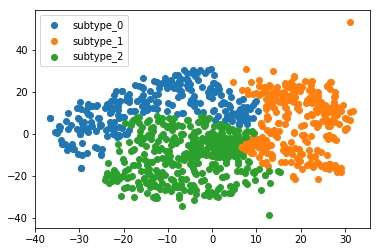

In [158]:
EV.cluster_visualization(tsne_data)

The function 'progression_plot()' will generate the curve for each subtypes in different selected features. The curve displayes how each subtypes change over the visits, and through the distinction of curves, the performance of the clustering can be observed.

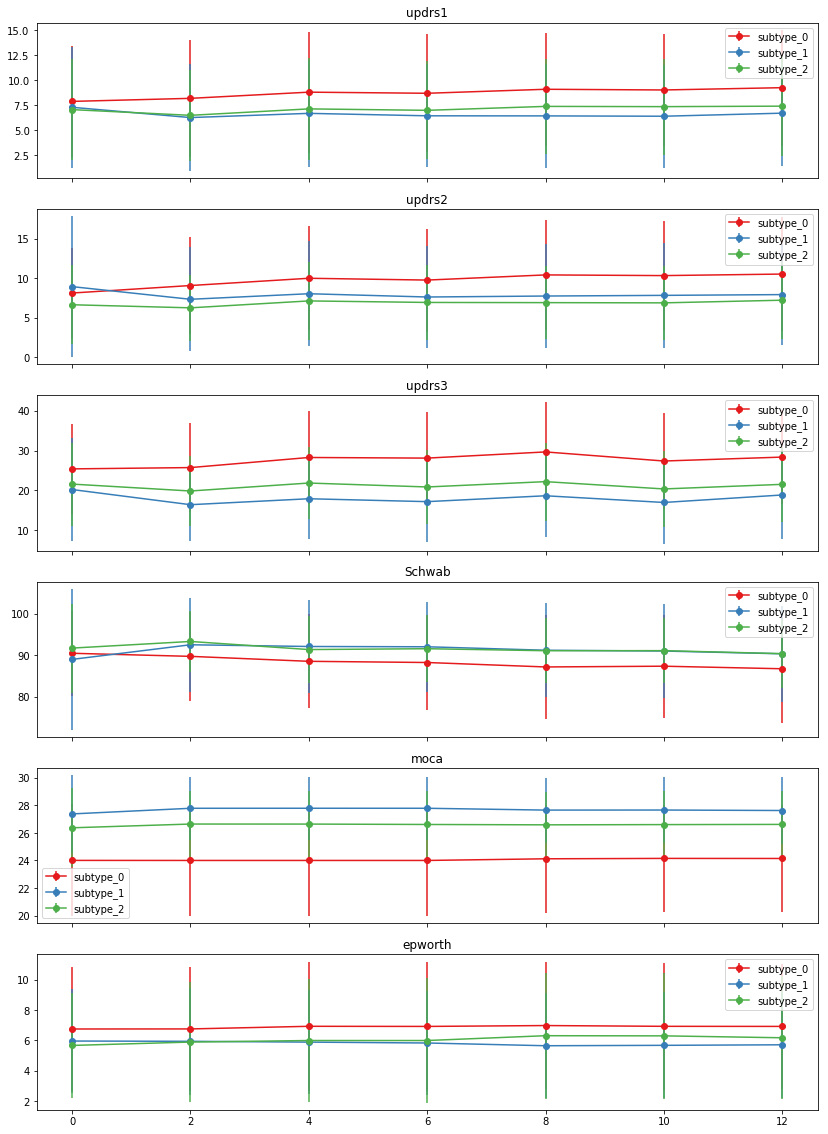

In [159]:
displayed_features = ['updrs1', 'updrs2', 'updrs3', 'Schwab', 'moca', 'epworth']
EV.progression_plot(tables, displayed_features)